In [15]:
# %%
# Env
import dotenv
dotenv.load_dotenv()

import sys, os
dir_head = os.environ.get("REPO_DIR", ".")
sys.path.insert(0, os.path.join(dir_head, "src"))

import numpy as np
from pixell import enmap

import warnings
import itertools
from scipy.ndimage import gaussian_filter
import multiprocessing
from functools import partial

warnings.filterwarnings("ignore")

# Files from the src dir in git
import utils as ut
import covariance as cov

import matplotlib.pyplot as plt
import random
import scipy


In [2]:
# Setup
config_data_fname = os.environ["REPO_DIR"] + "/configs/config_mcmc_ajay.yaml"
config_data = ut.get_config_file(config_data_fname)

cluster_region = ut.get_region(region_center_ra=config_data['region_center_ra'], 
                               region_center_dec=config_data['region_center_dec'],
                               region_width=config_data['region_width'])

fname = os.getenv("ACT_DATADIR") + "act_cut_dr6v2_pa5_f150_4way_coadd_map_srcfree.fits"

save_cov = 1
plot_1d = 0
plot_2d = 0

data_ref = ut.imap_dim_check(enmap.read_map(fname=fname, box=cluster_region))
data_shape, data_wcs = data_ref.shape, data_ref.wcs
geometry = (data_shape, data_wcs)
# if save_cov: 
#     os.system(f"rm -rf {os.environ['COV_DIR']}/cov_*npy*")

Calculating for: ('98_pa5_act_dr6v2', '98_pa5_act_dr6v2')
Smoothing the total power spectrum.


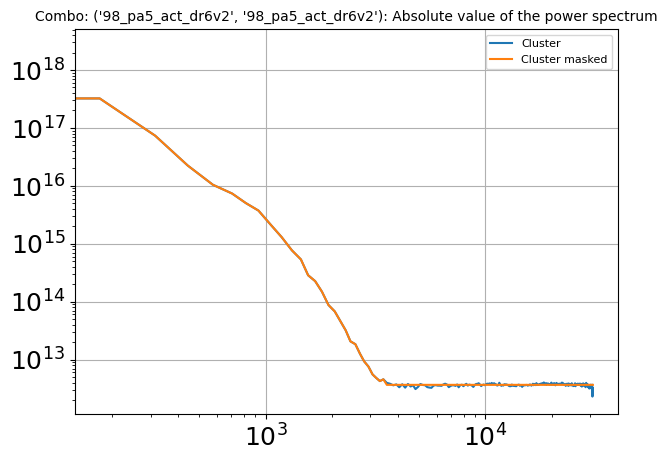

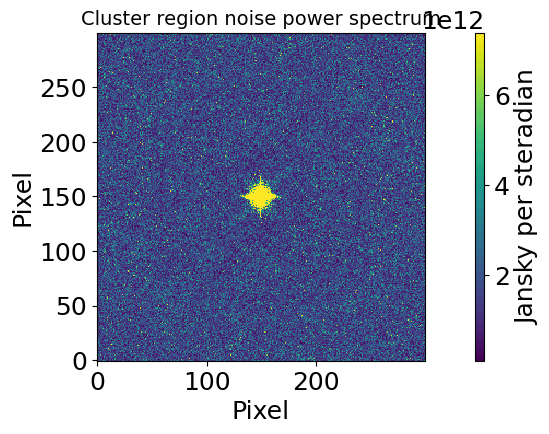

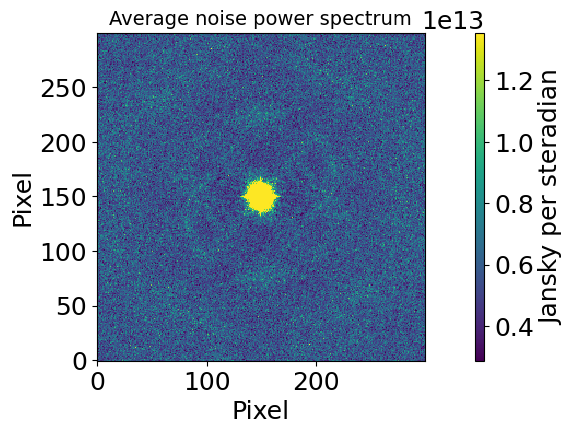

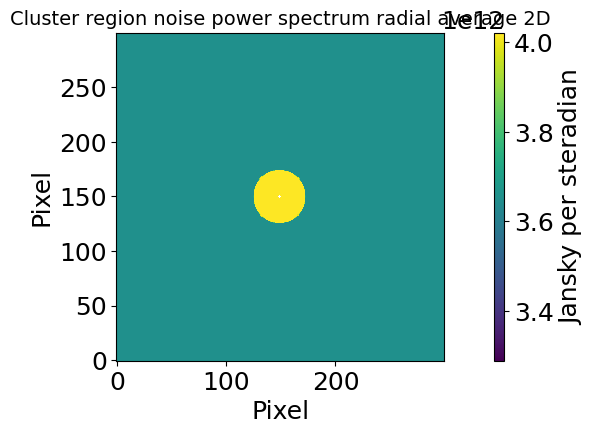

nan nan


In [21]:
# Calculate covariances
combos = list(itertools.product(config_data['data'], config_data['data']))
binsize = 125

# flags
plot_1d = 1
plot_2d = 1
plot_regions = 0
plot_2d_rad_ave = 0
whiten_planck = 1
whiten_act = 1

for combo in combos:
    freq1 = combo[0].split('_')[0]
    array1 = combo[0].split('_')[1]
    inst1 = combo[0].split('_')[2]
    scan1 = combo[0].split('_')[3]

    freq2 = combo[1].split('_')[0]
    array2 = combo[1].split('_')[1]
    inst2 = combo[1].split('_')[2]
    scan2 = combo[1].split('_')[3]

    if combo[0] != combo[1]: continue

    if inst1 == 'act':
        data_dir1 = os.getenv("ACT_DATADIR")
    elif inst1 == 'planck':
        data_dir1 = os.getenv("PLANCK_DATADIR")

    if inst2 == 'act':
        data_dir2 = os.getenv("ACT_DATADIR")
    elif inst2 == 'planck':
        data_dir2 = os.getenv("PLANCK_DATADIR")

    print("Calculating for: {}".format(combo))

    mean_tpsd, mean_npsd, mean_spsd, all_regions_npsd, all_regions_spsd = cov.get_covariance(freq1=freq1, 
                                                                                freq2=freq2,
                                            
                                                                                array1=array1, 
                                                                                array2=array2,
                                            
                                                                                inst1=inst1, 
                                                                                inst2=inst2,
                                            
                                                                                data_dir1=data_dir1,
                                                                                data_dir2=data_dir2,
                                                                                
                                                                                data_wcs=data_wcs,
                                                                                
                                                                                cf=config_data)
    
    cluster_tpsd = np.abs(mean_spsd) + np.abs(all_regions_npsd[-1])

    if plot_regions:
        for i, region in enumerate(all_regions_npsd):
            label = f"Region {i}"
            if i == 8: label = "Cluster"
            ut.plot_image(np.fft.fftshift(np.abs(all_regions_npsd[i])), 
                          interval_type="zscale", title=label)
    
    # Radial average
    b_cluster, l_cluster = enmap.lbin(map=cluster_tpsd, bsize=binsize)
    tpsd_fit_2d = cov.fit_one_over_f(l_npsd=l_cluster, b_npsd=b_cluster,
                                     mask_value=250, geometry=geometry)
    
    if plot_2d_rad_ave:
        ut.plot_image(np.fft.fftshift(tpsd_fit_2d), interval_type="zscale", 
                      title="Cluster region noise power spectrum radial average")
        
    # b_ave, l_ave = enmap.lbin(map=tpsd_fit_2d, bsize=binsize)
    # mask = l_cluster > 3500
    
    # b_masked = b_cluster
    # b_masked[mask] = np.mean(b_cluster[mask])

    # # convert to 2D 
    # modlmap = enmap.modlmap(*geometry)

    # interp_func = scipy.interpolate.interp1d(np.log10(l_cluster), np.log10(b_masked), fill_value="extrapolate")

    # b_masked_2d = 10**interp_func(np.log10(modlmap))

    if plot_1d:
        b_cluster, l_cluster = enmap.lbin(map=cluster_tpsd, bsize=binsize)
        b_tpsd, l_tpsd = enmap.lbin(map=np.abs(mean_tpsd), bsize=binsize)

        plt.figure(figsize=(7, 5))
        plt.loglog(l_cluster, b_cluster, label="Cluster")
        #plt.loglog(l_tpsd, b_tpsd, label="Averaging")
        # plt.loglog(l_ave, b_ave, label="Radial averaging")
        plt.title(f"Combo: {combo}: Absolute value of the power spectrum", fontsize=10)
        plt.legend(fontsize=8)
        plt.grid()
        plt.show()

    if plot_2d:
        ut.plot_image(np.fft.fftshift(np.abs(all_regions_npsd[-1])), 
                      interval_type="zscale", title="Cluster region noise power spectrum")
        # plot average noise power spectrum
        ut.plot_image(np.fft.fftshift(np.abs(mean_npsd)), 
                      interval_type="zscale", title="Average noise power spectrum")

In [20]:
b_masked_2d

array([[           nan,            nan, 8.61311921e+16, ...,
        2.22721535e+16, 8.61311921e+16,            nan],
       [           nan, 2.15784247e+17, 6.30554231e+16, ...,
        1.92622775e+16, 6.30554231e+16, 2.15784247e+17],
       [9.23315842e+16, 6.67459563e+16, 2.86322875e+16, ...,
        1.33771677e+16, 2.86322875e+16, 6.67459563e+16],
       ...,
       [2.44755734e+16, 2.05203546e+16, 1.37902700e+16, ...,
        9.20931943e+15, 1.37902700e+16, 2.05203546e+16],
       [9.23315842e+16, 6.67459563e+16, 2.86322875e+16, ...,
        1.33771677e+16, 2.86322875e+16, 6.67459563e+16],
       [           nan, 2.15784247e+17, 6.30554231e+16, ...,
        1.92622775e+16, 6.30554231e+16, 2.15784247e+17]])